In [1]:
# Алексеев Д.П. (DSU-4,FEML-8)
# Домашнее задание к лекции «Алгоритмы кластеризации» (#11).

# Данные:
# В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). 
# В них комментарии жителей города были застенографированы, проклассифицированы (за/против) и нанесены на карту. 

# Данные предоставлены в 2 вариантах, для задания можно использовать любой:
# 1) geo_comment.xlsx
# - comment - комментарий одного или списка жителей к проект
# - multiplier - количество авторов комментария (может быть 1, может быть список)
# - x, y - координаты адреса, по которому был дан определённой комментарий
# - comment_class - за (1) / против (-1)

# 2) geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть multiplier > 1 голоса)
# - x, y - координаты адреса, по которому был дан определённой комментарий
# - comment_class - за (1) / против (-1)

# Обязательное задание:
# - визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
# - аналогично исследовать скопления голосов за и против отдельно
# - подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)
# - приложить ноутбук

# Дополнительные задания:
# - найти наиболее активные в голосовании районы 
# (подсказка: DBSCAN, неплотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')
# - для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, 
# можно использовать всю имеющуюся дополнительную информацию.

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (12, 9)

In [3]:
df = pd.read_excel("E:\\Netology\\Machine Learning\\Practice\\geo.xlsx")
df.head()

,Unnamed: 0,x,y,comment_class
0,0,37.612416,55.777454,-1
1,1,37.612416,55.777454,-1
2,2,37.603298,55.742108,-1
3,3,37.558526,55.728758,-1
4,4,37.566431,55.731794,-1


In [4]:
# удалим ненужную 1-ую колонку
del df['Unnamed: 0']
df.head()

,x,y,comment_class
0,37.612416,55.777454,-1
1,37.612416,55.777454,-1
2,37.603298,55.742108,-1
3,37.558526,55.728758,-1
4,37.566431,55.731794,-1


In [5]:
df.describe()

,x,y,comment_class
count,108806.000000,108806.000000,108806.000000
mean,37.567532,55.766346,-0.748929
std,0.121996,0.069622,0.662653
min,37.148813,55.496939,-1.000000
25%,37.454528,55.729797,-1.000000
50%,37.559640,55.764734,-1.000000
75%,37.684784,55.806869,-1.000000
max,37.931228,55.994174,1.000000


In [6]:
# сделаем стандартизацию координат (x, y). Данные по голосам (comment_class) стандартизации не требуют.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [7]:
coords_scaled = scaler.fit_transform(df[['x','y']])
coords_scaled

array([[ 0.36791896,  0.15955291],
       [ 0.36791896,  0.15955291],
       [ 0.2931784 , -0.34813064],
       ...,
       [-1.20058354,  1.1836816 ],
       [-0.97563233,  0.38377766],
       [-0.95317246,  1.00936916]])

In [8]:
df['comment_class'].value_counts()
# мы видим, что голоса "против" (-1) существенно преобладают: 95147 голосов "против", 13659 голосов "за".

-1    95147
 1    13659
Name: comment_class, dtype: int64

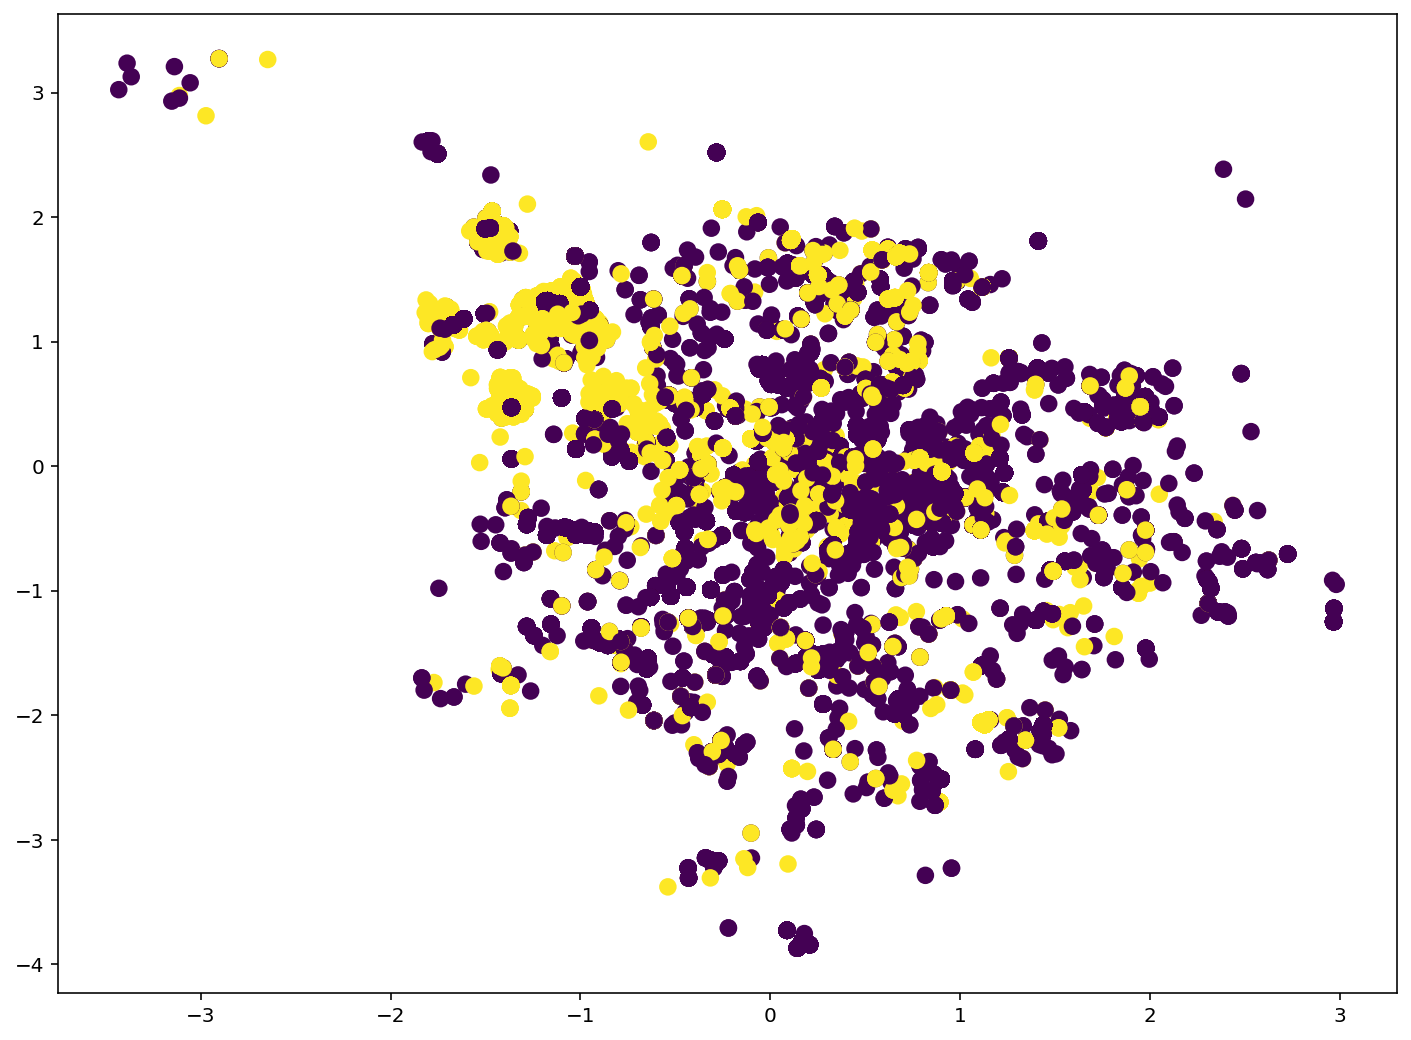

In [9]:
# предварительно построим scatter plot без кластеризации и без разделения массива на голоса "За" и "Против".
# Желтым цветом выделены голоса "За" (1), фиолетовым - "Против" (-1)
plt.scatter(coords_scaled[:, 0], coords_scaled[:, 1], c=df['comment_class'], s=60)

Ещё до проведения кластеризации заметно, что много голосов "за" сосредоточено на северо-западе Москвы.
Много голосов "против" - в центральных районах.

In [10]:
# попробуем теперь сделать кластеризацию с помощью алгоритма KMeans с параметрами "по умолчанию"
from sklearn.cluster import KMeans

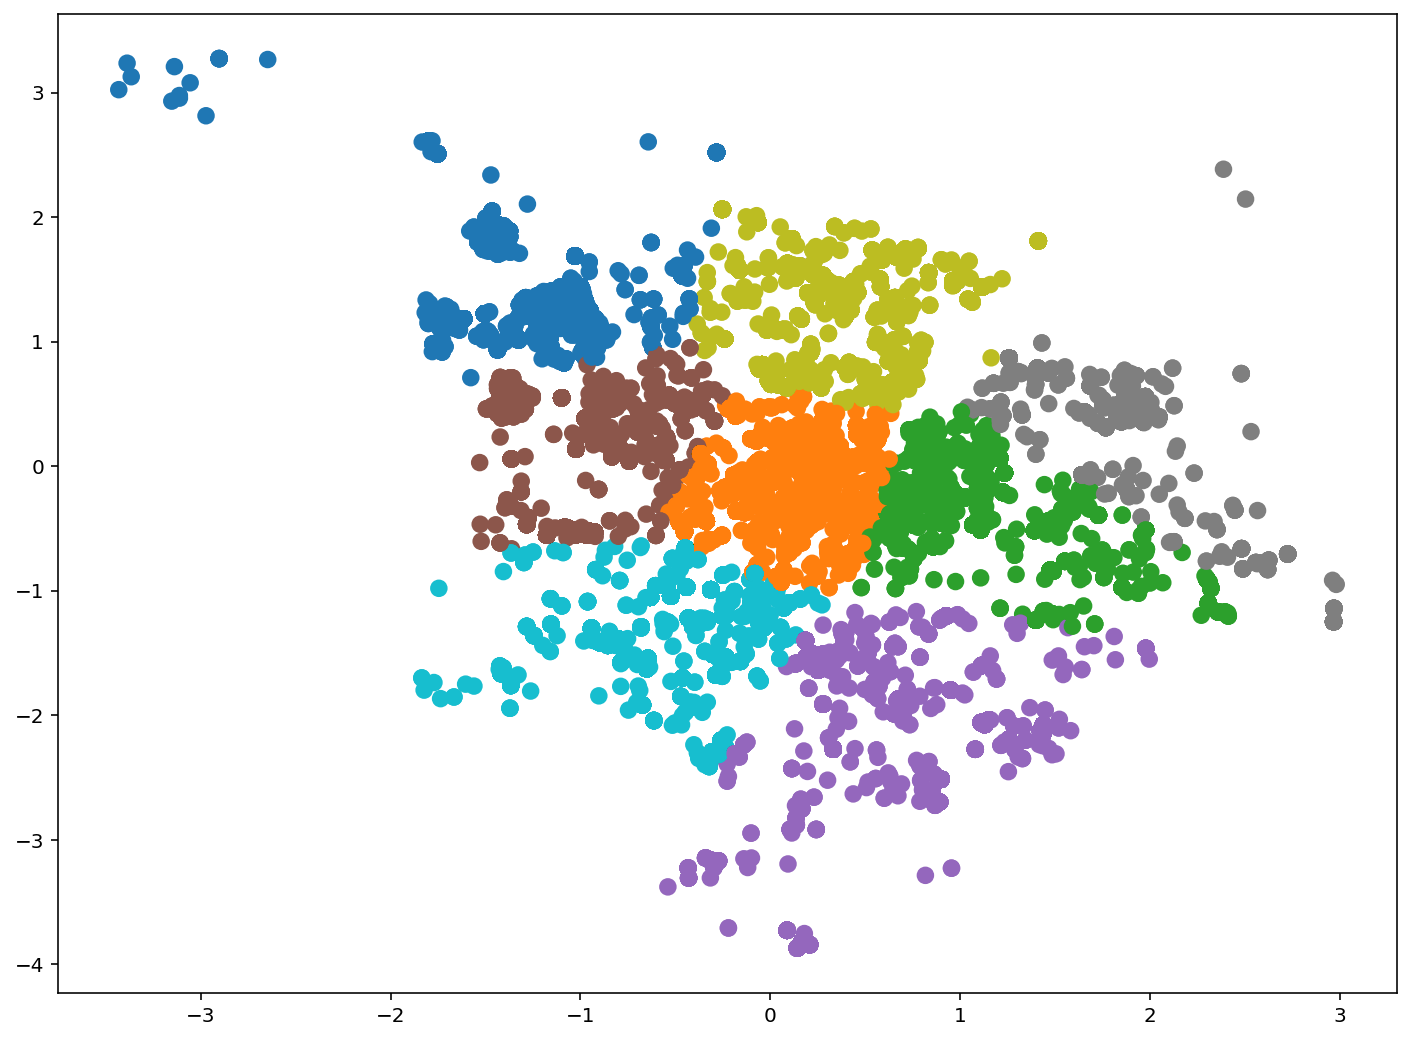

In [11]:
clf_kmeans = KMeans()
clusters_kmeans = clf_kmeans.fit_predict(coords_scaled)

plt.scatter(coords_scaled[:, 0], coords_scaled[:, 1], c=clusters_kmeans, cmap='tab10', s=60)

Мы видим, что получилось 8 кластеров, это достаточно много. 
Попробуем провести оптимизацию кластеризации при помощи параметра inertia_

In [12]:
k_inertia = []
ks = range(1,11)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(coords_scaled, )
    k_inertia.append(clf_kmeans.inertia_)

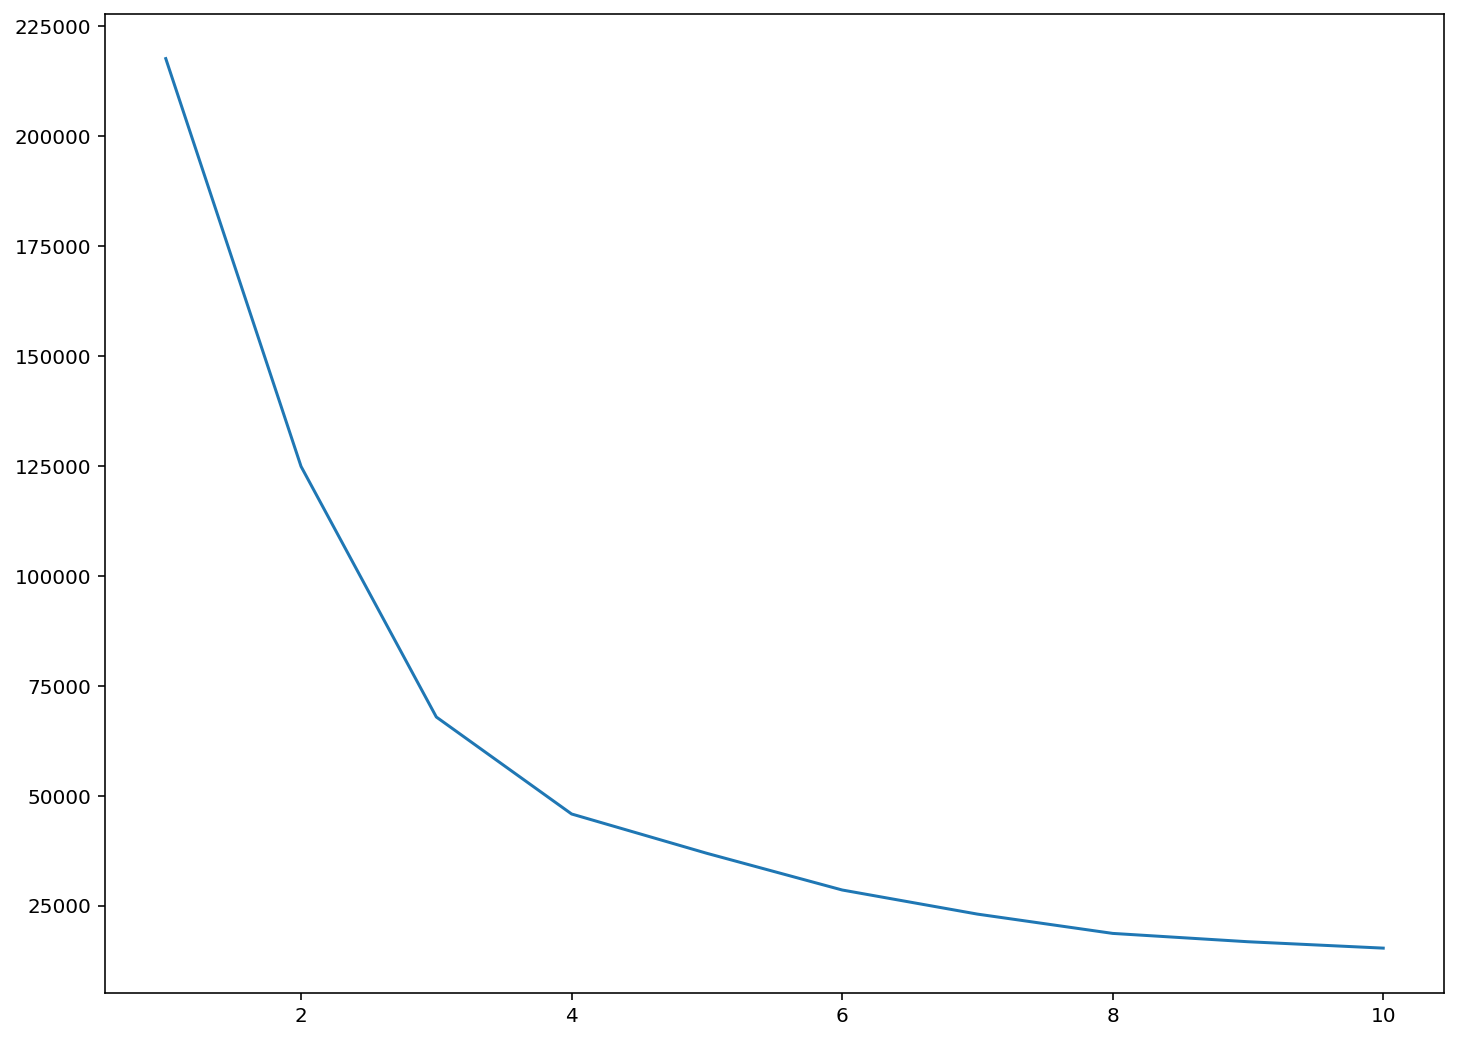

In [13]:
plt.plot(ks, k_inertia)

Как подобрать оптимальное значение? 
Будем на каждом шаге смотреть изменение inertia, и в тот момент, 
когда оно резко замедлится (относительно предыдущего изменения), мы и остановимся.

Для начала считаем сами изменения по формуле:
    $${inertia_{k+1}-inertia_{k}}$$

In [14]:
diff = np.diff(k_inertia)

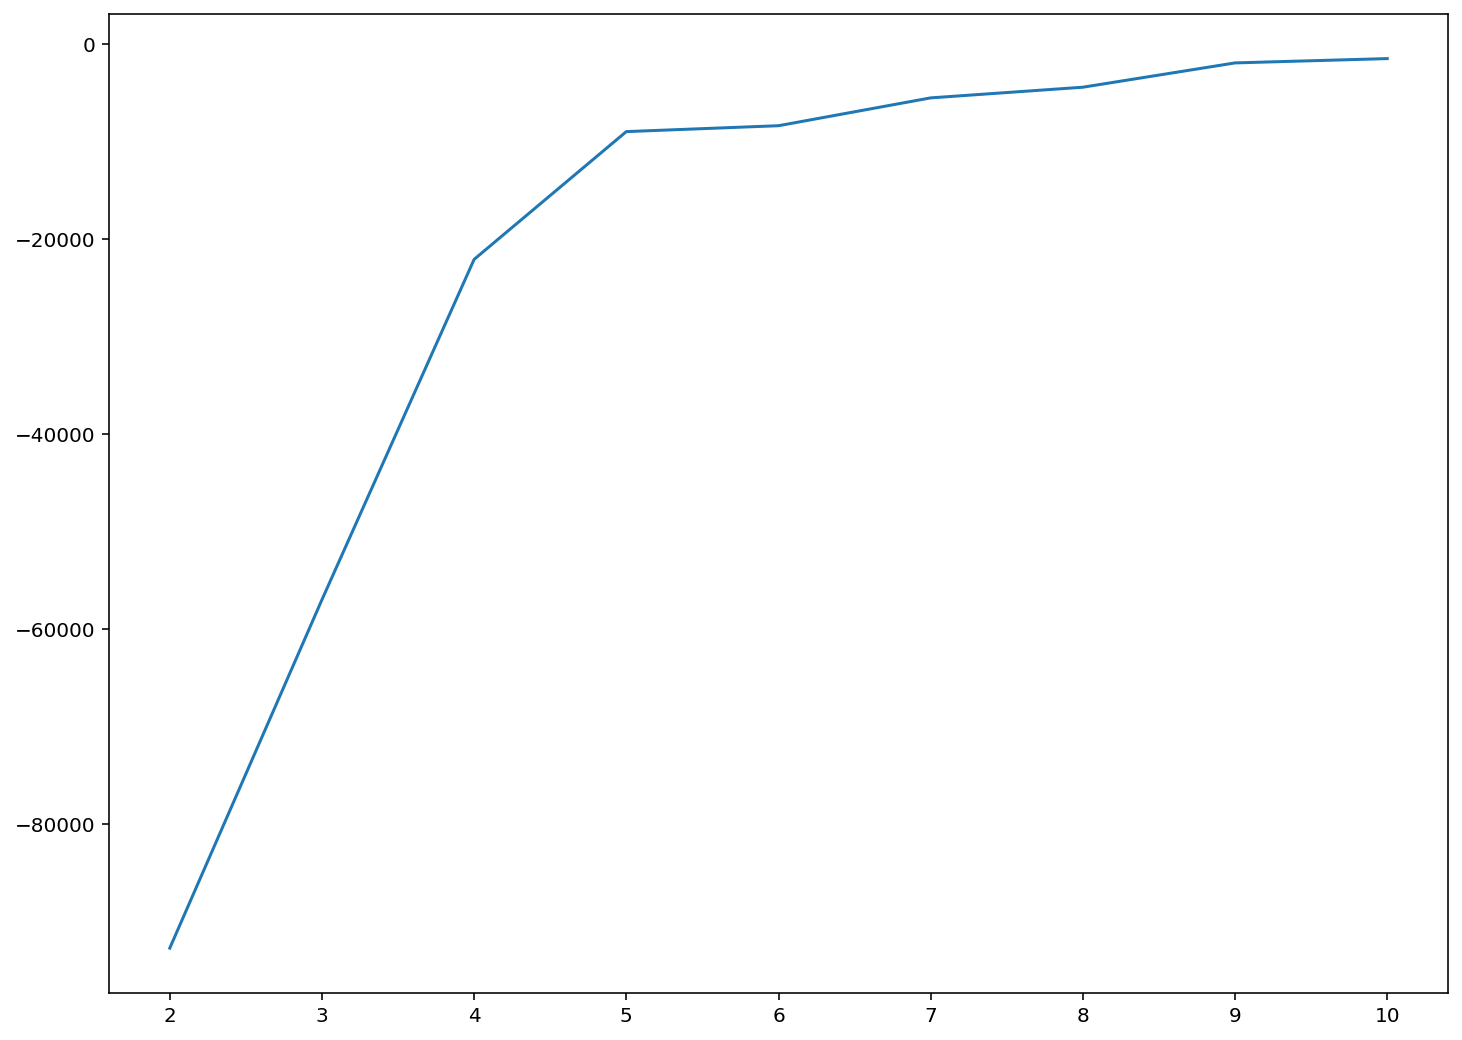

In [15]:
plt.plot(ks[1:], diff)

Теперь можно найти оптимальное число кластеров по этой формуле: 
    $$k_{opt} = argmin(\frac{inertia_{k+1}-inertia_{k}}{inertia_{k}-inertia_{k-1}})$$

In [16]:
diff_r = diff[1:] / diff[:-1]

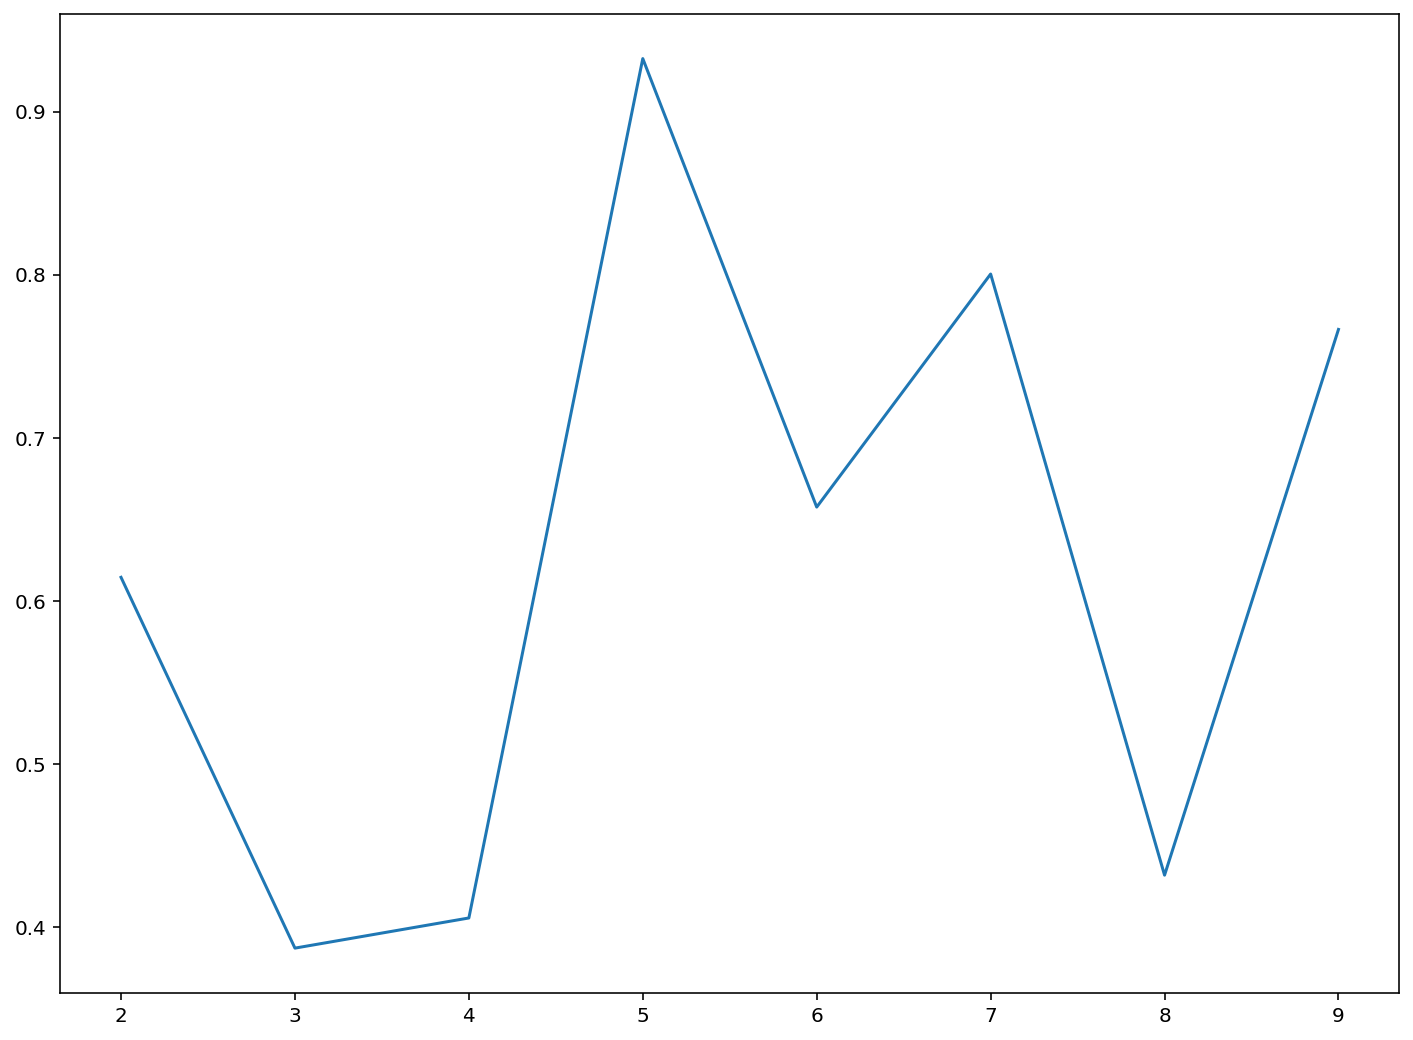

In [17]:
plt.plot(ks[1:-1], diff_r)

In [18]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

3

Мы видим, что оптимальное количество кластеров = 3.

При 8-и, кстати, тоже "почти" оптимально - при кластеризации с параметрами "по умолчанию" получилось как раз 8 кластеров.

Попробуем сделать кластеризацию на 3 кластера.

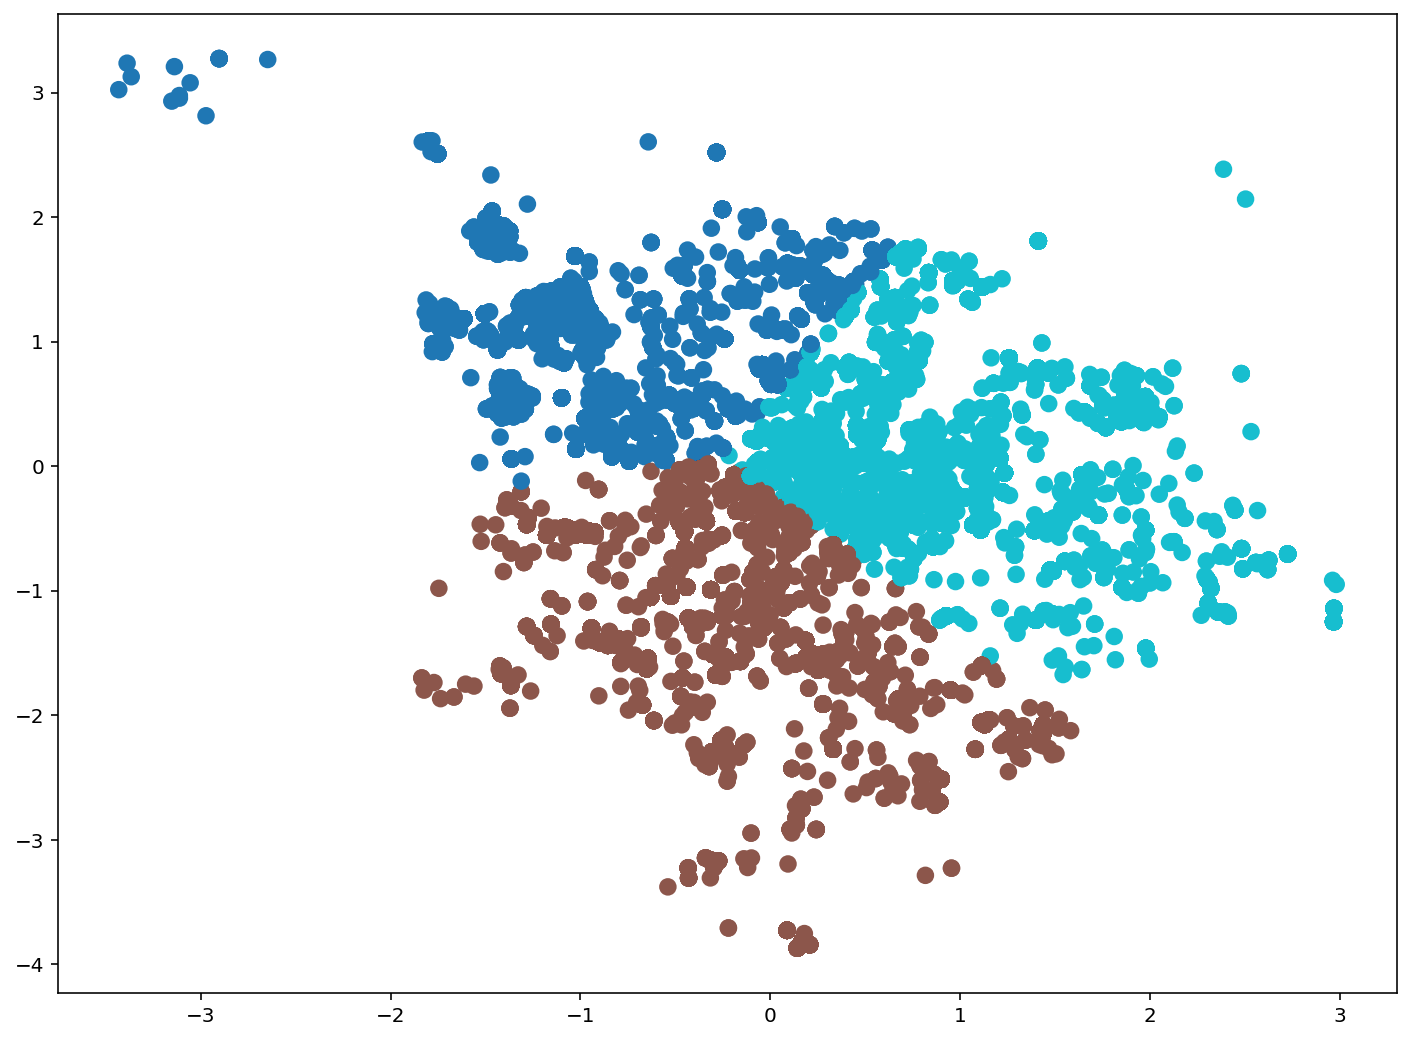

In [19]:
clf_kmeans = KMeans(n_clusters=3)
clusters_kmeans = clf_kmeans.fit_predict(coords_scaled)

plt.scatter(coords_scaled[:, 0], coords_scaled[:, 1], c=clusters_kmeans, cmap='tab10', s=60)

Проведем теперь кластеризацию только по голосам "За" ('comment_class'] = 1).

In [20]:
df_pro = df[df['comment_class'] == 1]
df_pro.describe()

,x,y,comment_class
count,13659.000000,13659.000000,13659.0
mean,37.611202,55.783328,1.0
std,0.133448,0.062006,0.0
min,37.187755,55.531173,1.0
25%,37.536742,55.741389,1.0
50%,37.570887,55.799532,1.0
75%,37.720950,55.826026,1.0
max,37.900039,55.994174,1.0


In [21]:
# сделаем стандартизацию на отобранном датасете
coords_pro_scaled = scaler.fit_transform(df_pro[['x','y']])
coords_pro_scaled

array([[-0.16701157, -0.66683515],
       [-0.1640515 , -0.79116702],
       [-0.3947497 , -0.88011374],
       ...,
       [-1.19866757,  0.85950028],
       [-1.17409523,  0.14520085],
       [-1.42485448,  1.05523145]])

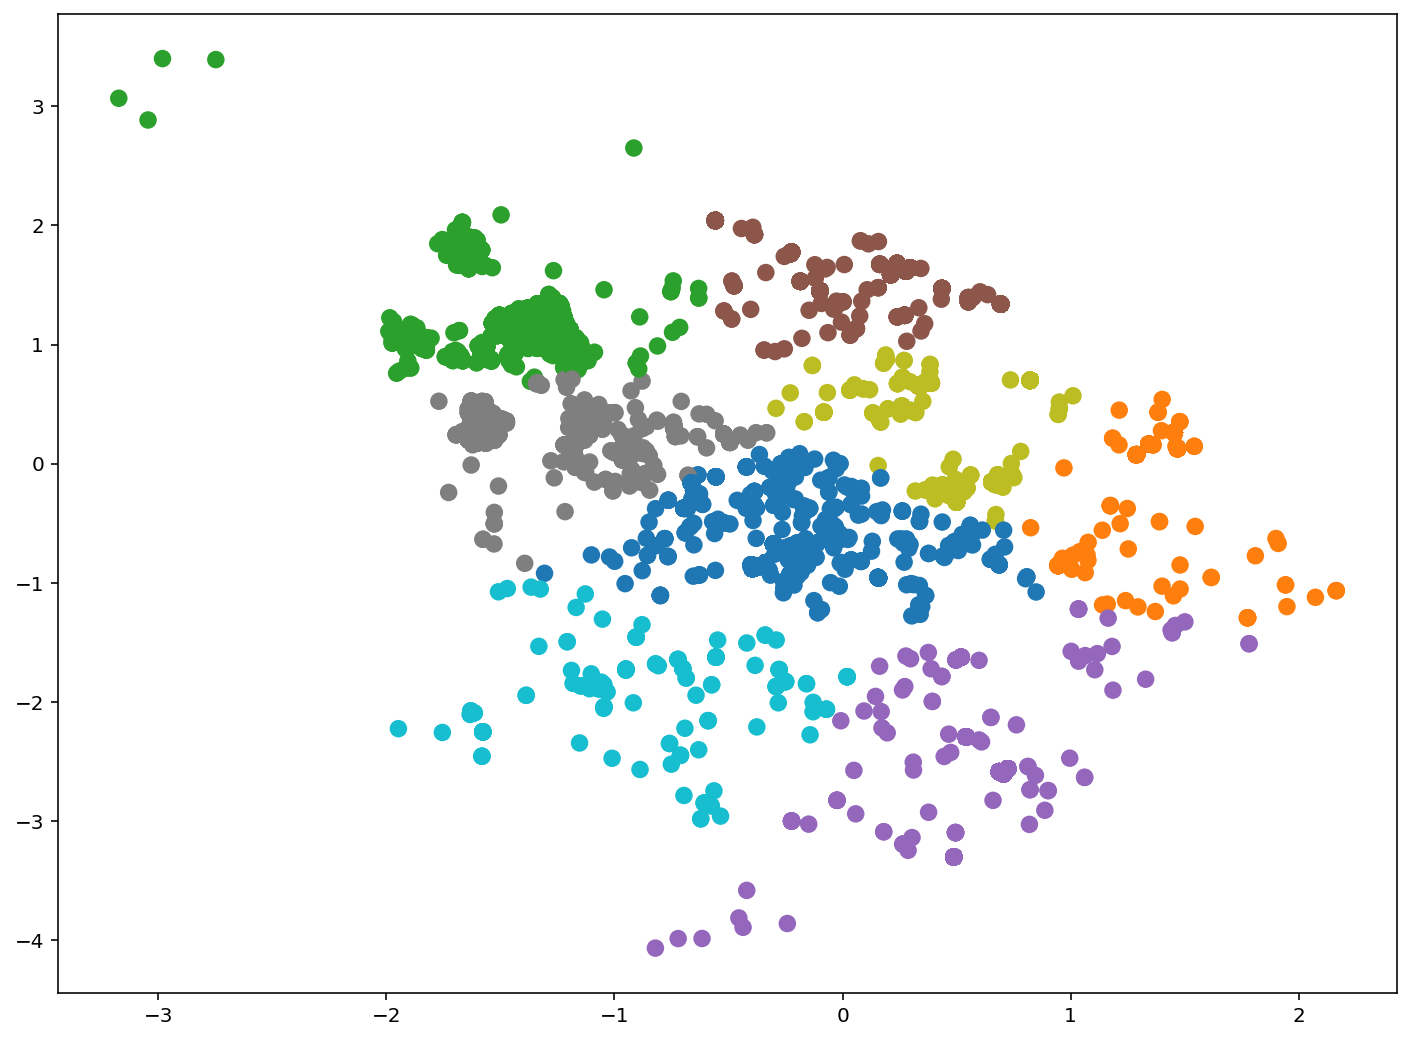

In [22]:
# кластеризация с параметрами "по умолчанию"
clf_kmeans = KMeans()
clusters_kmeans = clf_kmeans.fit_predict(coords_pro_scaled)

plt.scatter(coords_pro_scaled[:, 0], coords_pro_scaled[:, 1], c=clusters_kmeans, cmap='tab10', s=60)

Мы видим, что получились те же 8 кластеров, что и в "неразделенном" датасете.
На данном рисунке ещё более заметно, что голоса "за" преобладают в северо-западных районах, 
меньше всего голосов "за" - в восточных и юго-восточных районах столицы.

Попробуем провести оптимизацию кластеризации при помощи параметра inertia_

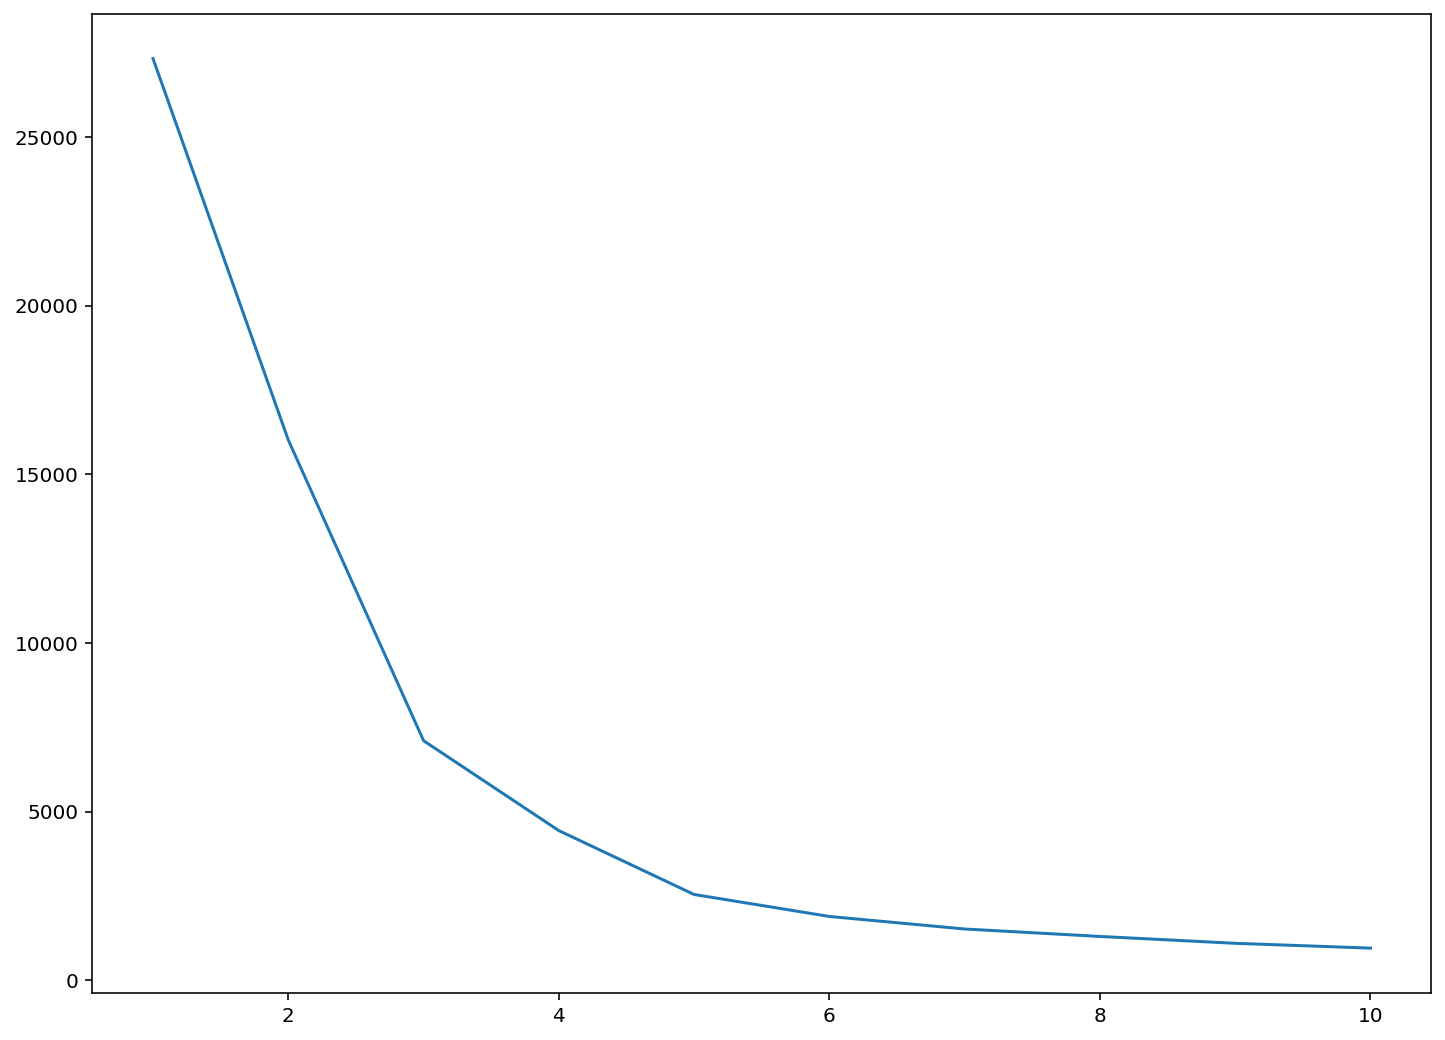

In [23]:
k_inertia = []
ks = range(1,11)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(coords_pro_scaled, )
    k_inertia.append(clf_kmeans.inertia_)
    
plt.plot(ks, k_inertia)

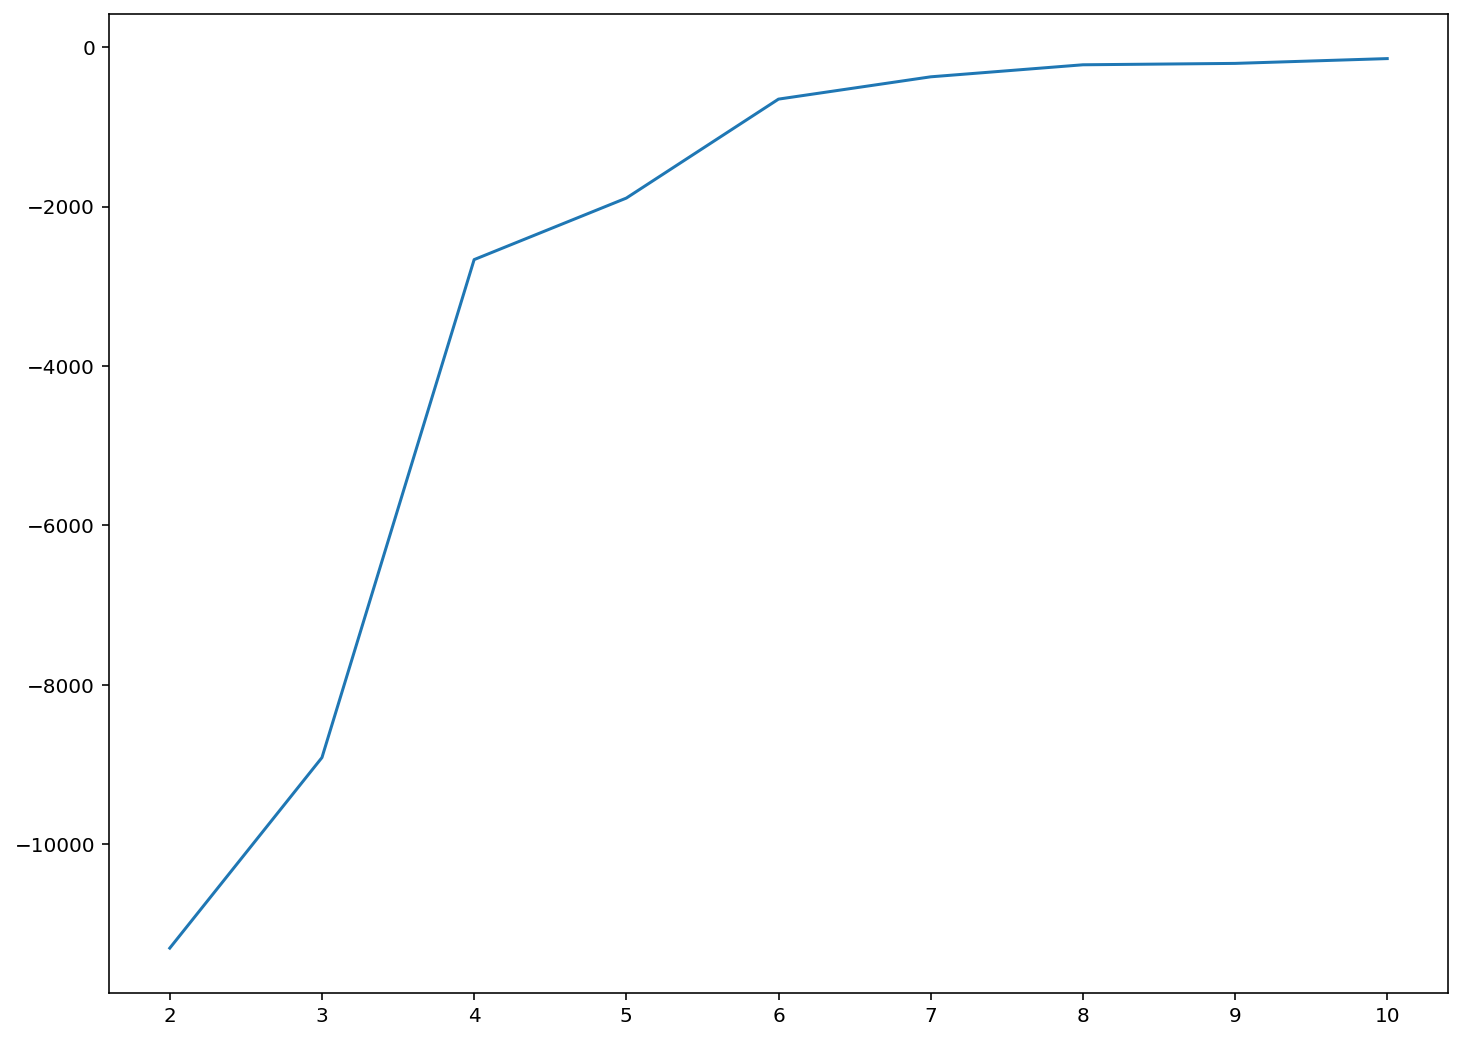

In [24]:
diff = np.diff(k_inertia)
plt.plot(ks[1:], diff)

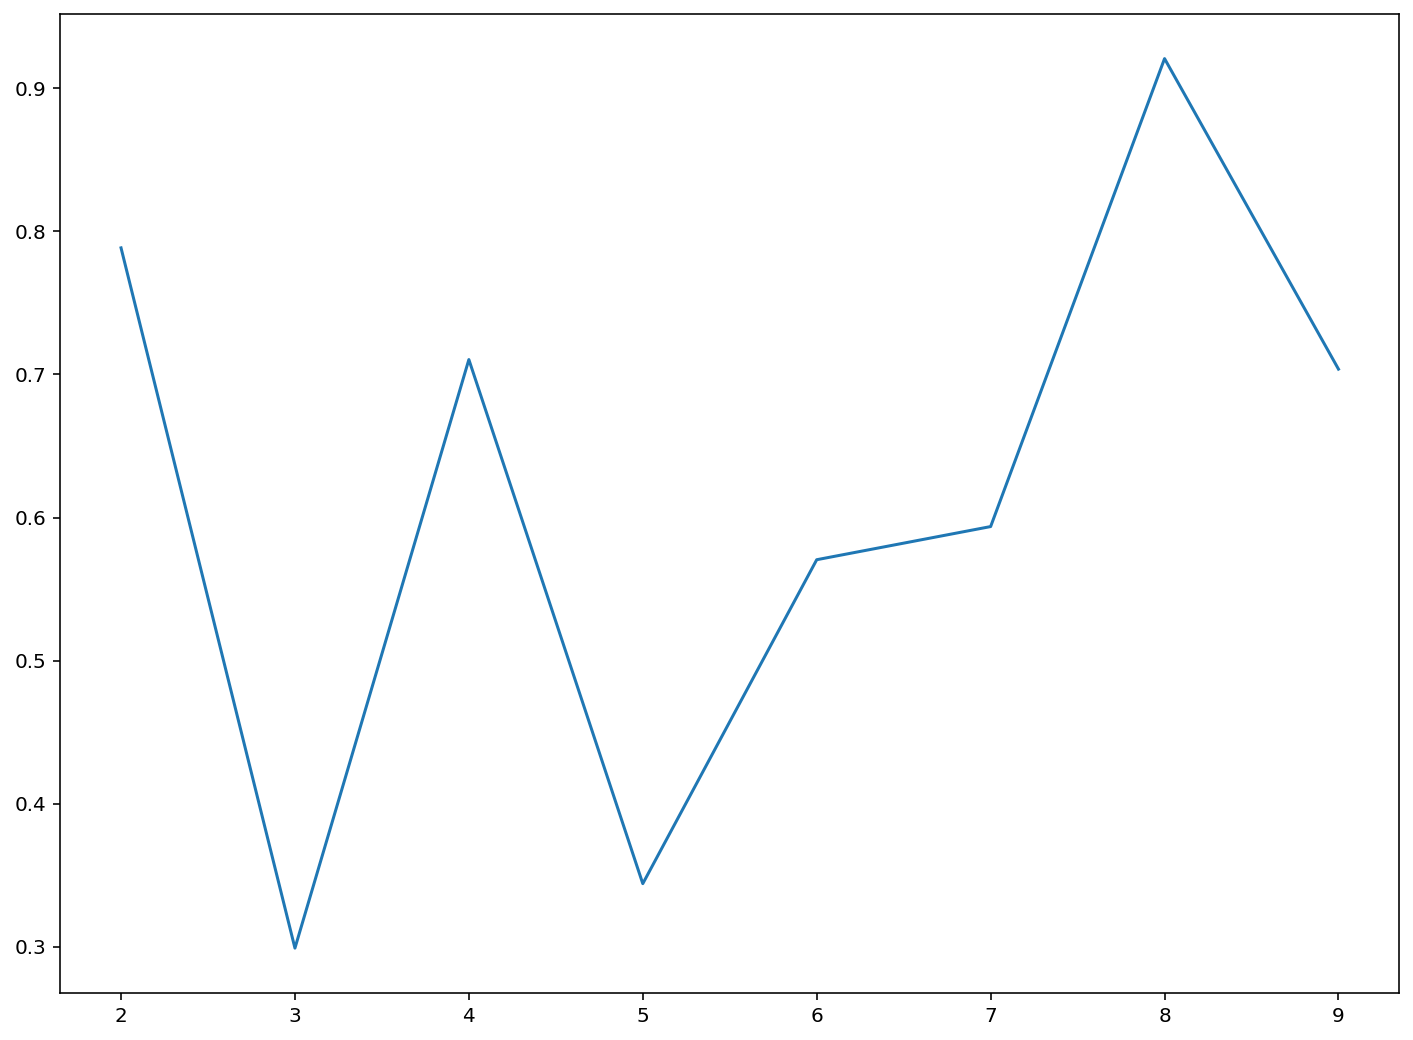

In [25]:
diff_r = diff[1:] / diff[:-1]
plt.plot(ks[1:-1], diff_r)

In [26]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

3

Мы видим, что оптимальное кол-во кластеров опять равно 3. "Предоптимальное" равно 5-и, 
т.е. разбивка с параметрами по умолчанию на 8 кластеров далека от оптимальной.

Разобьем голоса "за" на 3 оптимальных кластера.

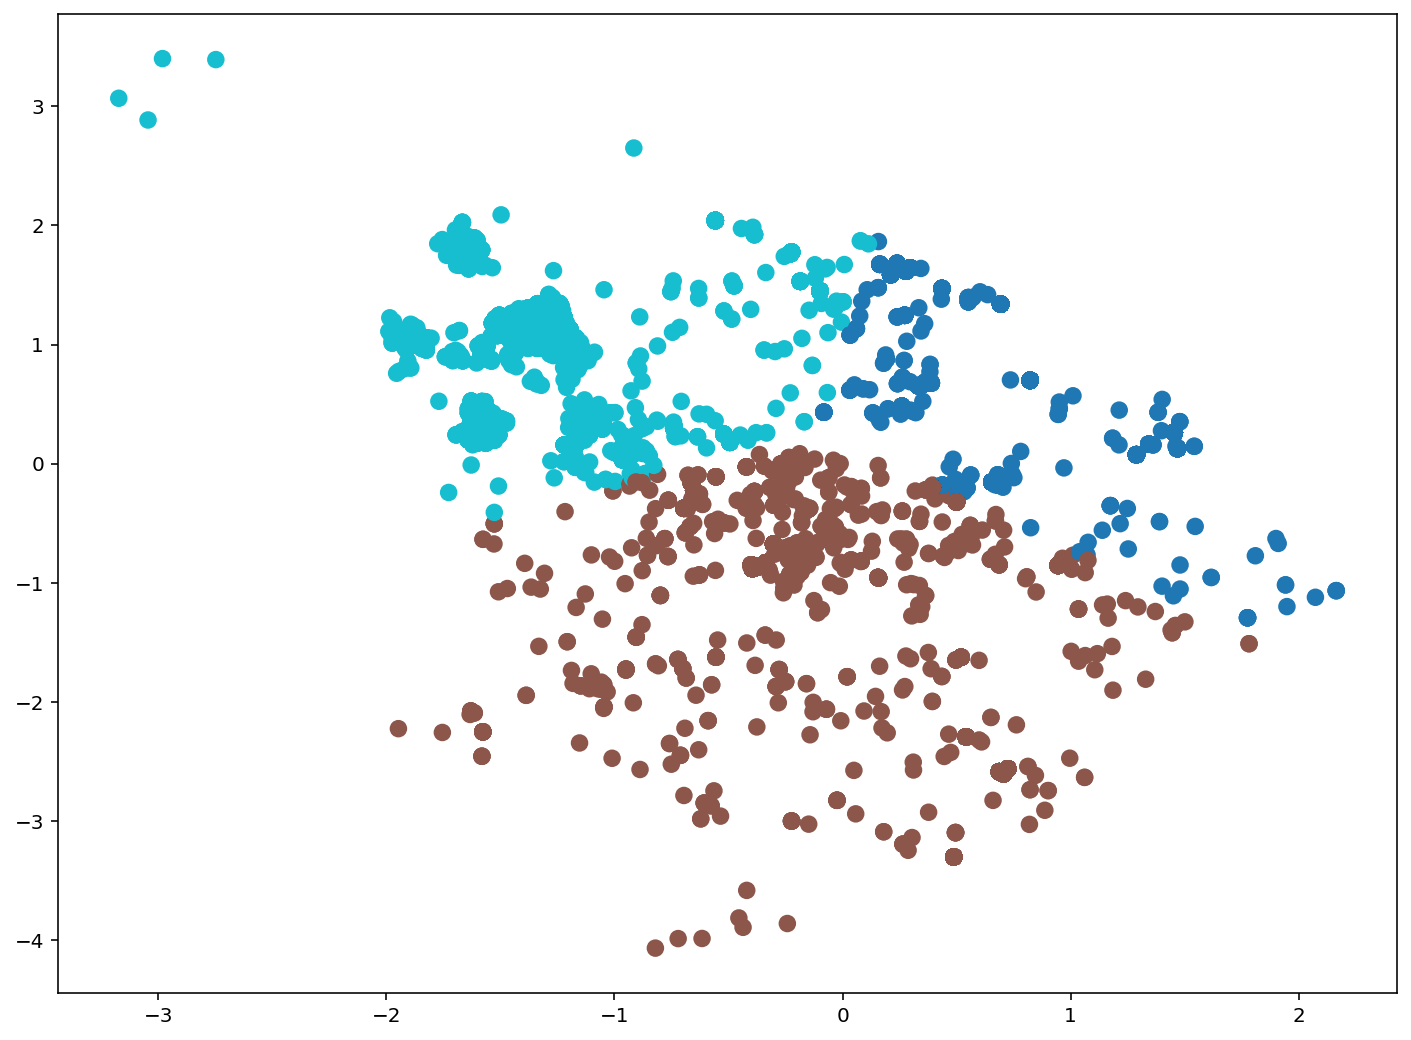

In [27]:
clf_kmeans = KMeans(n_clusters=3)
clusters_kmeans = clf_kmeans.fit_predict(coords_pro_scaled)

plt.scatter(coords_pro_scaled[:, 0], coords_pro_scaled[:, 1], c=clusters_kmeans, cmap='tab10', s=60)

Проведем тот же цикл процедур для голосов "против" ('comment_class' = -1).

In [28]:
df_contra = df[df['comment_class'] == -1]
df_contra.describe()

,x,y,comment_class
count,95147.000000,95147.000000,95147.0
mean,37.561262,55.763908,-1.0
std,0.118954,0.070313,0.0
min,37.148813,55.496939,-1.0
25%,37.454528,55.728758,-1.0
50%,37.545680,55.762576,-1.0
75%,37.683616,55.804891,-1.0
max,37.931228,55.994174,-1.0


In [29]:
# сделаем стандартизацию на отобранном датасете
coords_contra_scaled = scaler.fit_transform(df_contra[['x','y']])
coords_contra_scaled

array([[ 0.43002964,  0.19265922],
       [ 0.43002964,  0.19265922],
       [ 0.35337802, -0.31003917],
       ...,
       [-1.4874462 ,  1.92227958],
       [-0.94787529,  0.4146822 ],
       [-0.92484113,  1.03413074]])

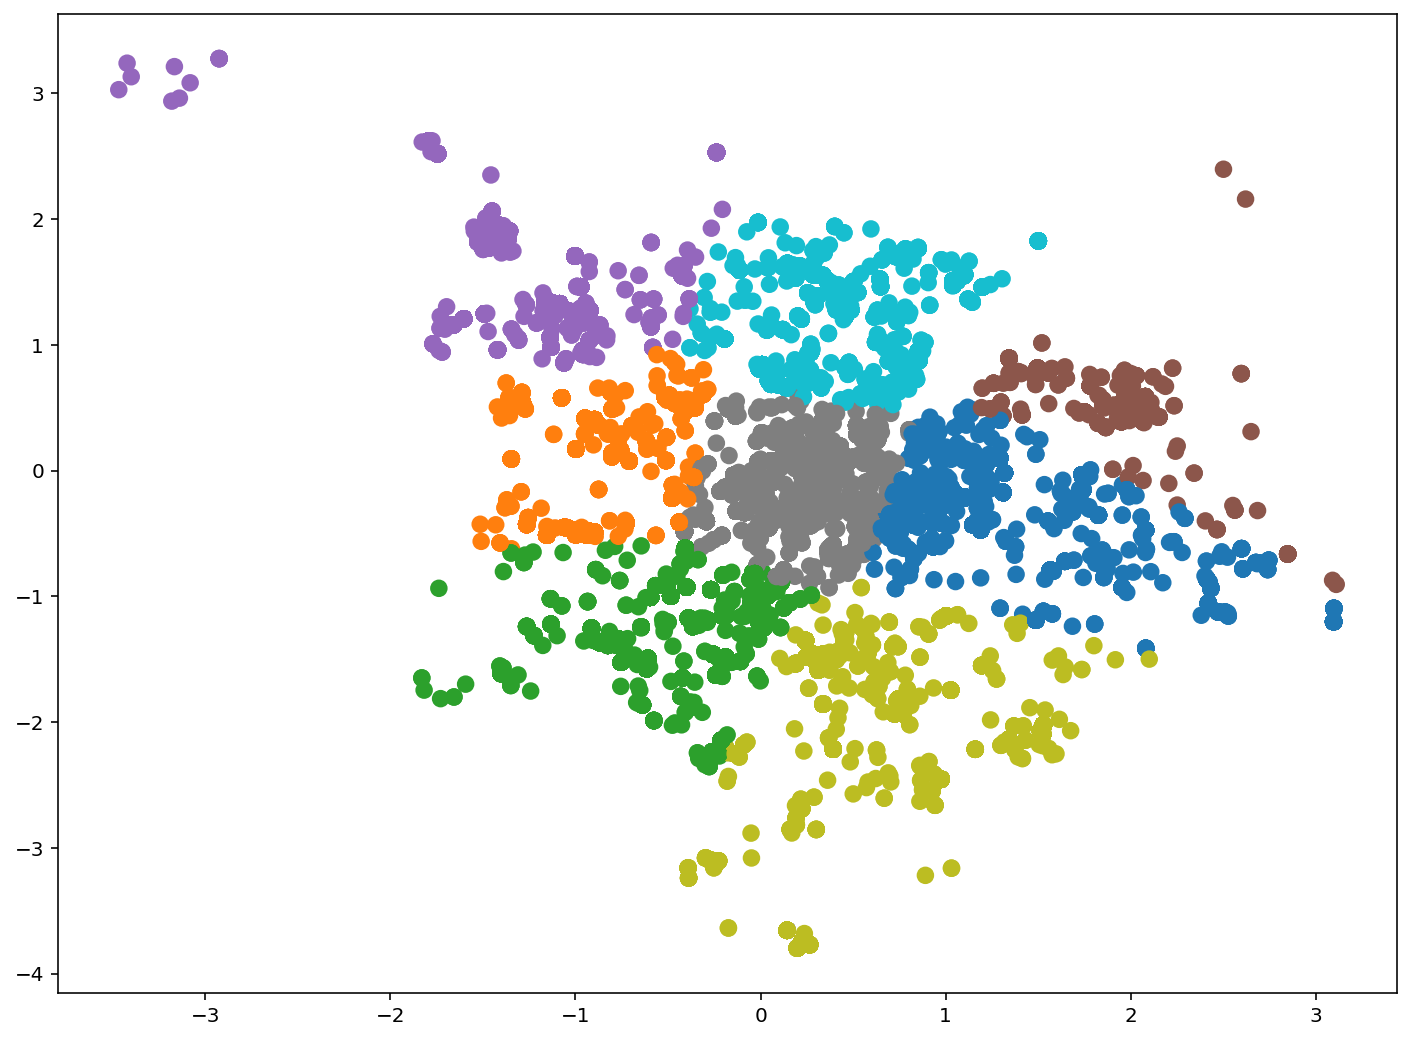

In [30]:
# кластеризация с параметрами "по умолчанию"
clf_kmeans = KMeans()
clusters_kmeans = clf_kmeans.fit_predict(coords_contra_scaled)

plt.scatter(coords_contra_scaled[:, 0], coords_contra_scaled[:, 1], c=clusters_kmeans, cmap='tab10', s=60)

Получились 8 кластеров, чётко выраженной привязки к географии не наблюдается. 
Но видно невооруженным глазом, что количество голосов "против" инициатив властей существенно больше, чем было на рисунке "за"))

Проведем оптимизацию кластеризации.

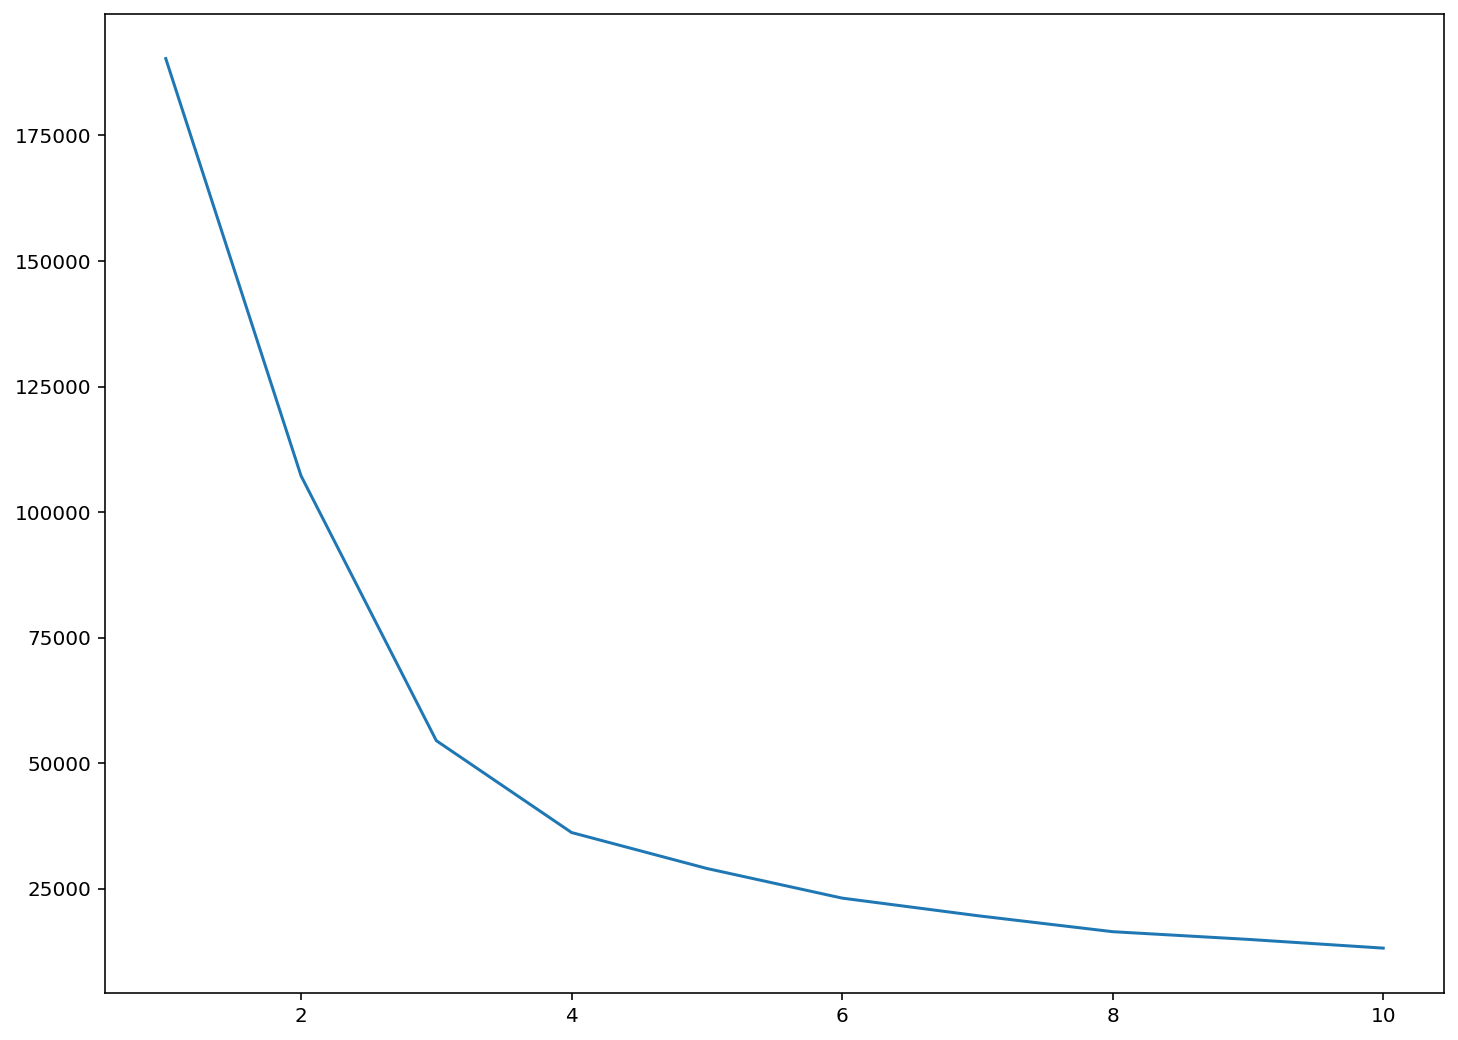

In [31]:
k_inertia = []
ks = range(1,11)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(coords_contra_scaled, )
    k_inertia.append(clf_kmeans.inertia_)
    
plt.plot(ks, k_inertia)

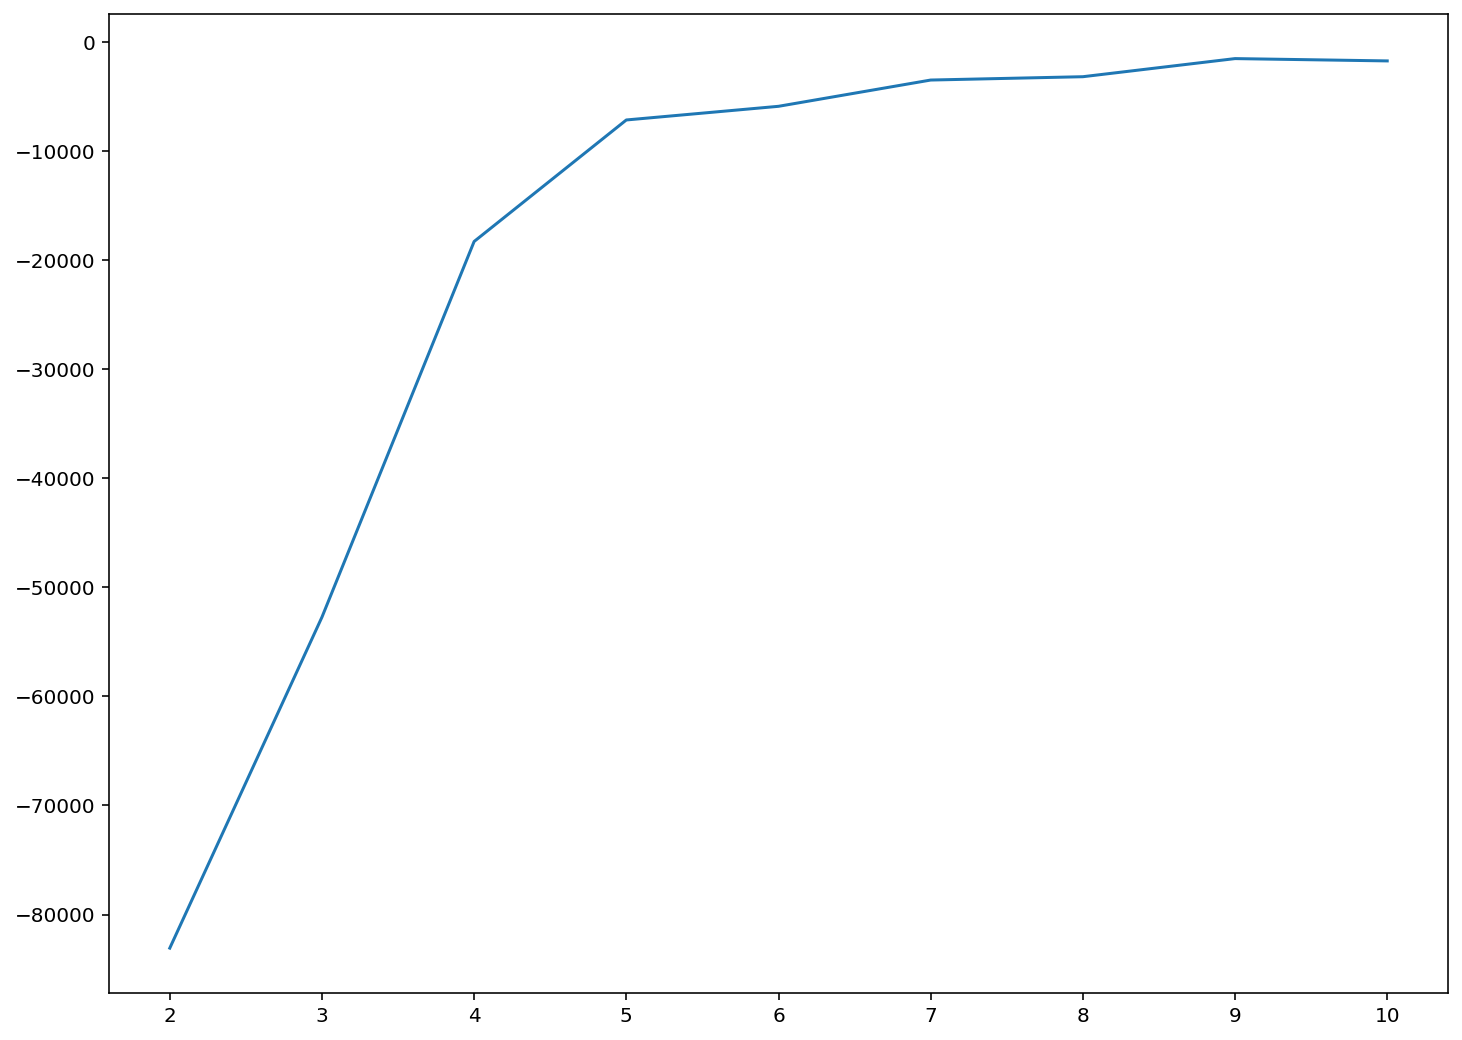

In [32]:
diff = np.diff(k_inertia)
plt.plot(ks[1:], diff)

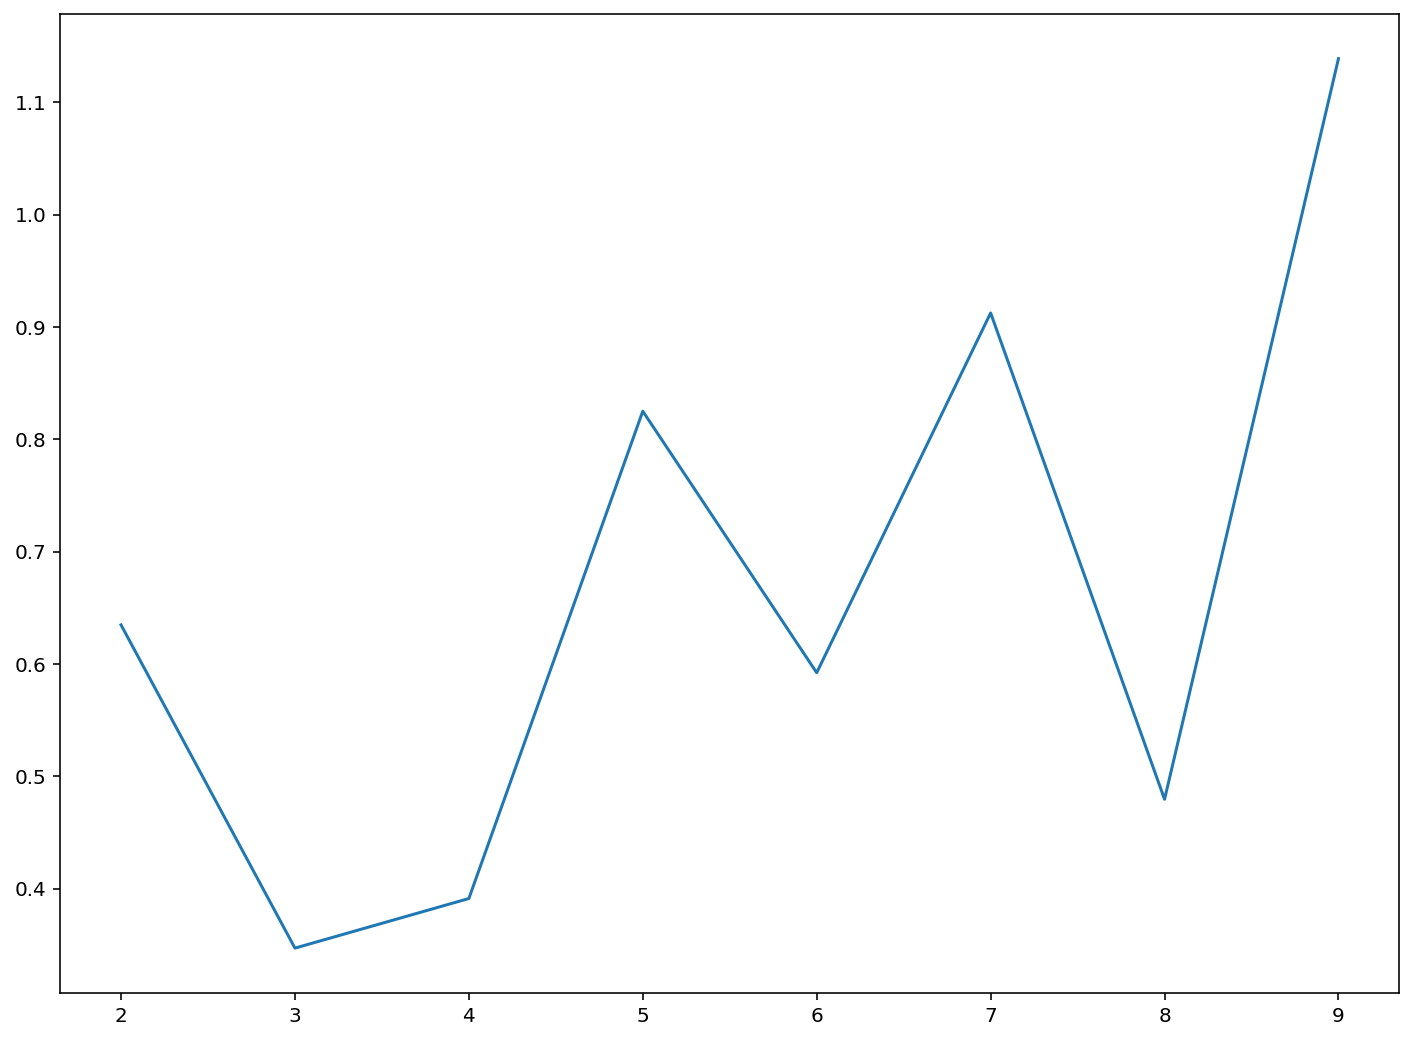

In [33]:
diff_r = diff[1:] / diff[:-1]
plt.plot(ks[1:-1], diff_r)

In [34]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

3

Мы видим, что оптимальное кол-во кластеров опять равно 3. "Предоптимальное" равно 4-м.
Разобьем голоса "против" на 3 оптимальных кластера, а потом на 4 (для сравнения).

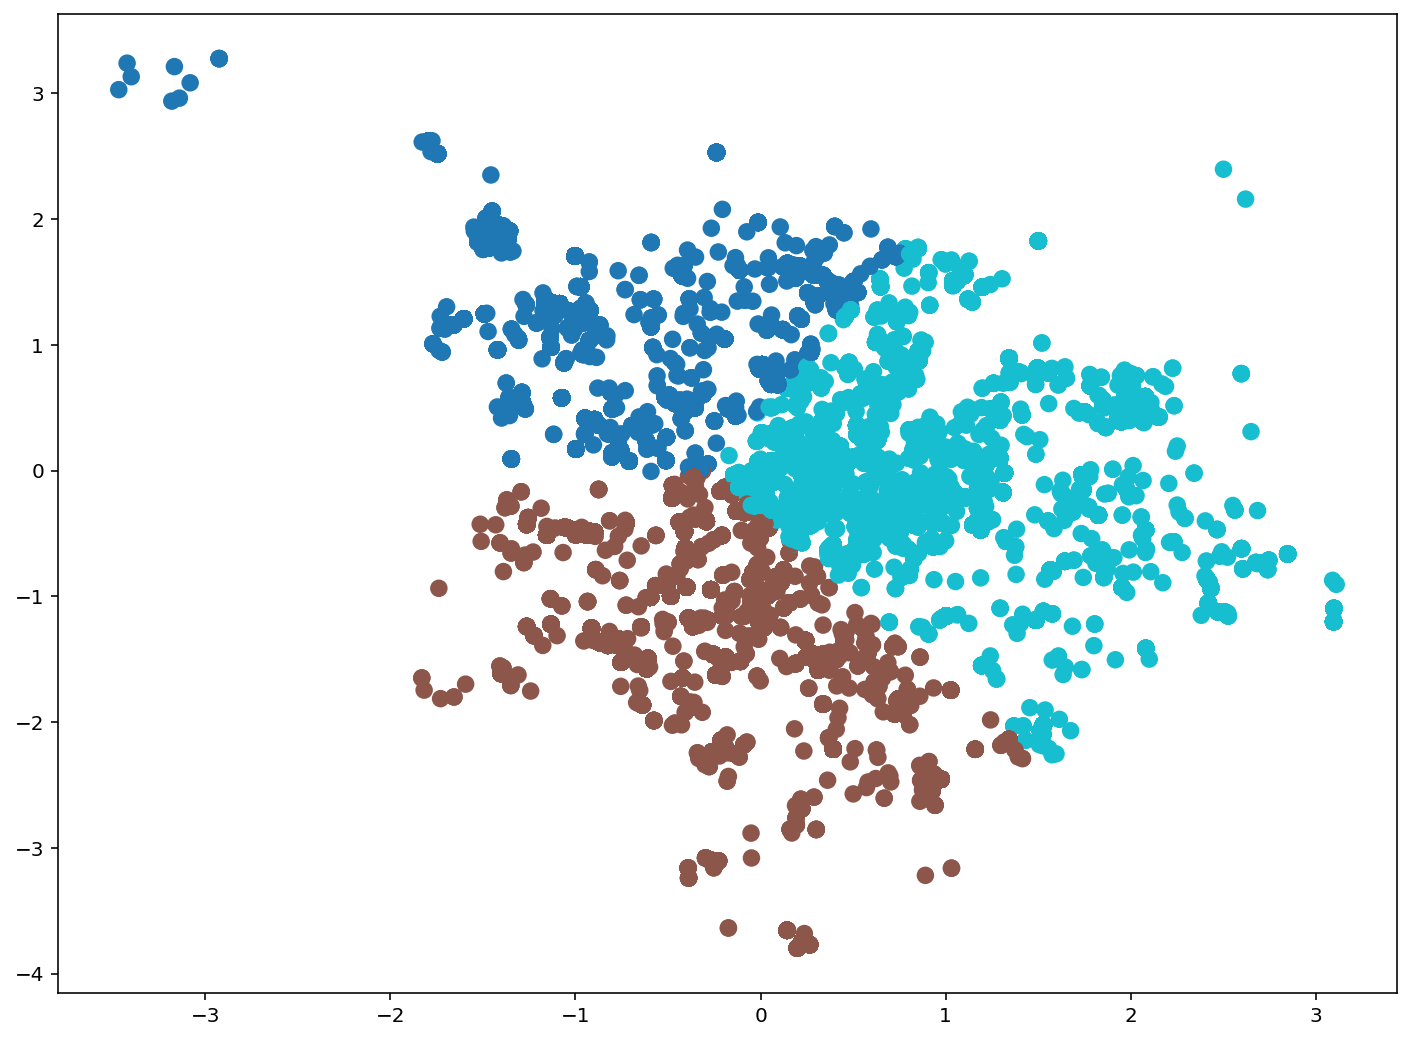

In [35]:
clf_kmeans = KMeans(n_clusters=3)
clusters_kmeans = clf_kmeans.fit_predict(coords_contra_scaled)

plt.scatter(coords_contra_scaled[:, 0], coords_contra_scaled[:, 1], c=clusters_kmeans, cmap='tab10', s=60)

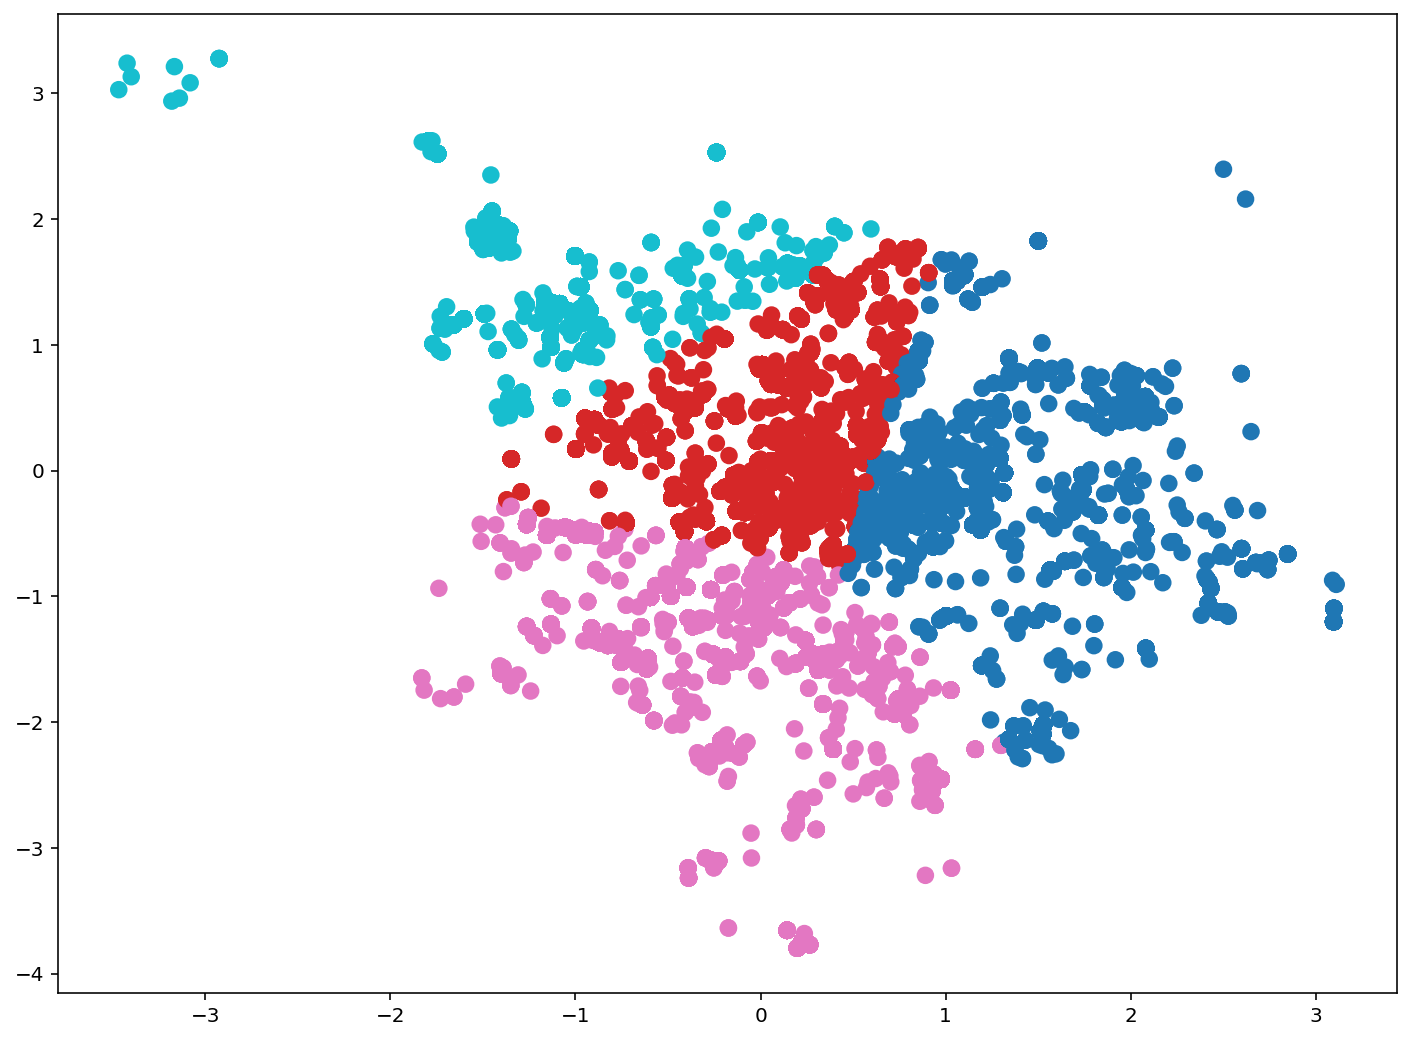

In [36]:
clf_kmeans = KMeans(n_clusters=4)
clusters_kmeans = clf_kmeans.fit_predict(coords_contra_scaled)

plt.scatter(coords_contra_scaled[:, 0], coords_contra_scaled[:, 1], c=clusters_kmeans, cmap='tab10', s=60)

На мой взгляд, разбивка голосов "против" на 4 кластера (а не на 3 "оптимальных") 
гораздо лучше коррелирует с картиной кластеризации голосов "за",
т.к. стал четко виден "северо-западный" кластер, где меньше всего голосов "против" и было больше всего голосов "за".

Дополнительное задание:
- найти наиболее активные в голосовании районы 
(подсказка: DBSCAN, неплотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')

In [37]:
from sklearn.cluster import DBSCAN

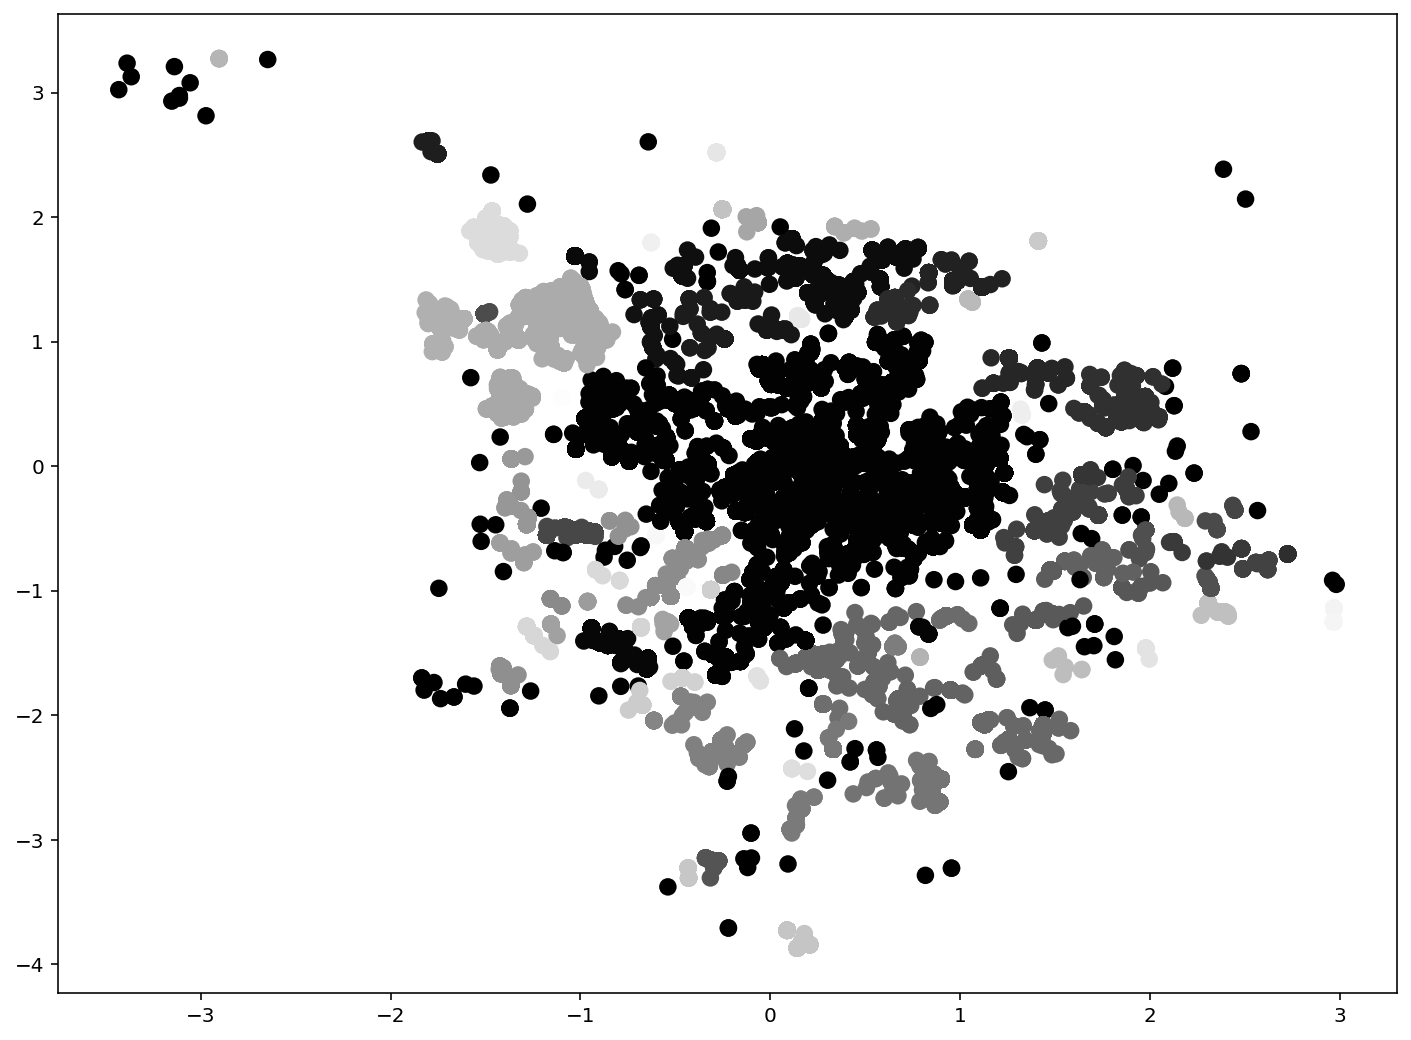

In [38]:
db_scan = DBSCAN(eps=0.1) # указываем eps
clusters = db_scan.fit_predict(coords_scaled) #используем массив без разбивки голосов на "за" и "против", т.к. нужны все голоса.
plt.scatter(coords_scaled[:, 0], coords_scaled[:, 1], c=clusters, cmap='gray', s=60)

Мы видим, что наиболее плотное голосование было в центральных и северных районах Москвы.
Наименее интенсивное - на северо-западе и юго-востоке.

Дополнительное задание:
- для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, 
можно использовать всю имеющуюся дополнительную информацию.

In [39]:
# если я правильно понял задание, то для выделения основных тематик комментариев можно использовать TFIDF
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [40]:
# загрузим файл, содержащий комменты жителей
df_comments = pd.read_excel("E:\\Netology\\Machine Learning\\Practice\\geo_comment.xlsx")
df_comments.head()

,Unnamed: 0,x,y,comment_class,multiplier,comment
0,0,37.612416,55.777454,-1,1,Во все разделы правил землепользования и застр...
1,1,37.612416,55.777454,-1,1,На основании вступившего в законную силу судеб...
2,2,37.603298,55.742108,-1,1,Внести в Проект правил землепользования и заст...
3,3,37.558526,55.728758,-1,1,Учитывая социальную значимость проекта строите...
4,4,37.566431,55.731794,-1,1,Учитывая социальную значимость проекта строите...


In [41]:
# удалим ненужную 1-ую колонку
del df_comments['Unnamed: 0']
df_comments.head()

,x,y,comment_class,multiplier,comment
0,37.612416,55.777454,-1,1,Во все разделы правил землепользования и застр...
1,37.612416,55.777454,-1,1,На основании вступившего в законную силу судеб...
2,37.603298,55.742108,-1,1,Внести в Проект правил землепользования и заст...
3,37.558526,55.728758,-1,1,Учитывая социальную значимость проекта строите...
4,37.566431,55.731794,-1,1,Учитывая социальную значимость проекта строите...


In [42]:
# инициализируем CountVectorizer() 
cv = CountVectorizer() 

# обучаем счетчик слов на поле с комментариями жителей
word_count_vector=cv.fit_transform(df_comments['comment'])

In [43]:
word_count_vector.shape

(70382, 36163)

In [44]:
# вычисляем IDF
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True) 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [45]:
# заполняем датафрейм с рассчитанными значениями IDF 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"])

# Сортируем веса IDF по возрастанию. 
# Наиболее частые тематики комментариев будут находиться в начале списка (с наименьшими значениями весов IDF)
df_idf.sort_values(by=['idf_weights']).head(50)

,idf_weights
на,1.066178
застройки,1.144932
по,1.237335
для,1.257827
территории,1.340769
строительство,1.358709
ул,1.359909
москвы,1.364358
не,1.406531
землепользования,1.406809


Если отжать "воду", то из анализа наиболее часто встречающихся слов можно сделать вывод, 
что основные тематики комментариев жителей касались голосования "против" на публичных слушаниях, 
проводимых по вопросам застройки городских территорий.